<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#PageRank" data-toc-modified-id="PageRank-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>PageRank</a></span><ul class="toc-item"><li><span><a href="#Taxation" data-toc-modified-id="Taxation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Taxation</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))

from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

%watermark -a 'Ethen' -d -t -v -p numpy,networkx,matplotlib

Ethen 2019-03-02 10:24:46 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.2
networkx 2.2
matplotlib 2.2.3


# PageRank

PageRank is a function that assigns a number weighting each page in the Web, the intent is that the higher the PageRank of a page, the more important the page is. We can think of the Web as a directed graph, where the pages are the nodes and if there exists a link that connects page1 to page2 then there would be an edge connecting the two nodes.

Imagine an toy example where there are only 4 pages/nodes, ${A, B, C, D}$:

- $A$ has links connecting itself to each of ther other three pages.
- $B$ has links to $A$ and $D$.
- $D$ has links to $B$ and $C$.
- $C$ has links only to $A$.

In [3]:
nodes = ['A', 'B', 'C', 'D']
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'D'),
    ('B', 'A'),
    ('B', 'D'),
    ('D', 'B'),
    ('D', 'C'),
    ('C', 'A')
]

graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
graph

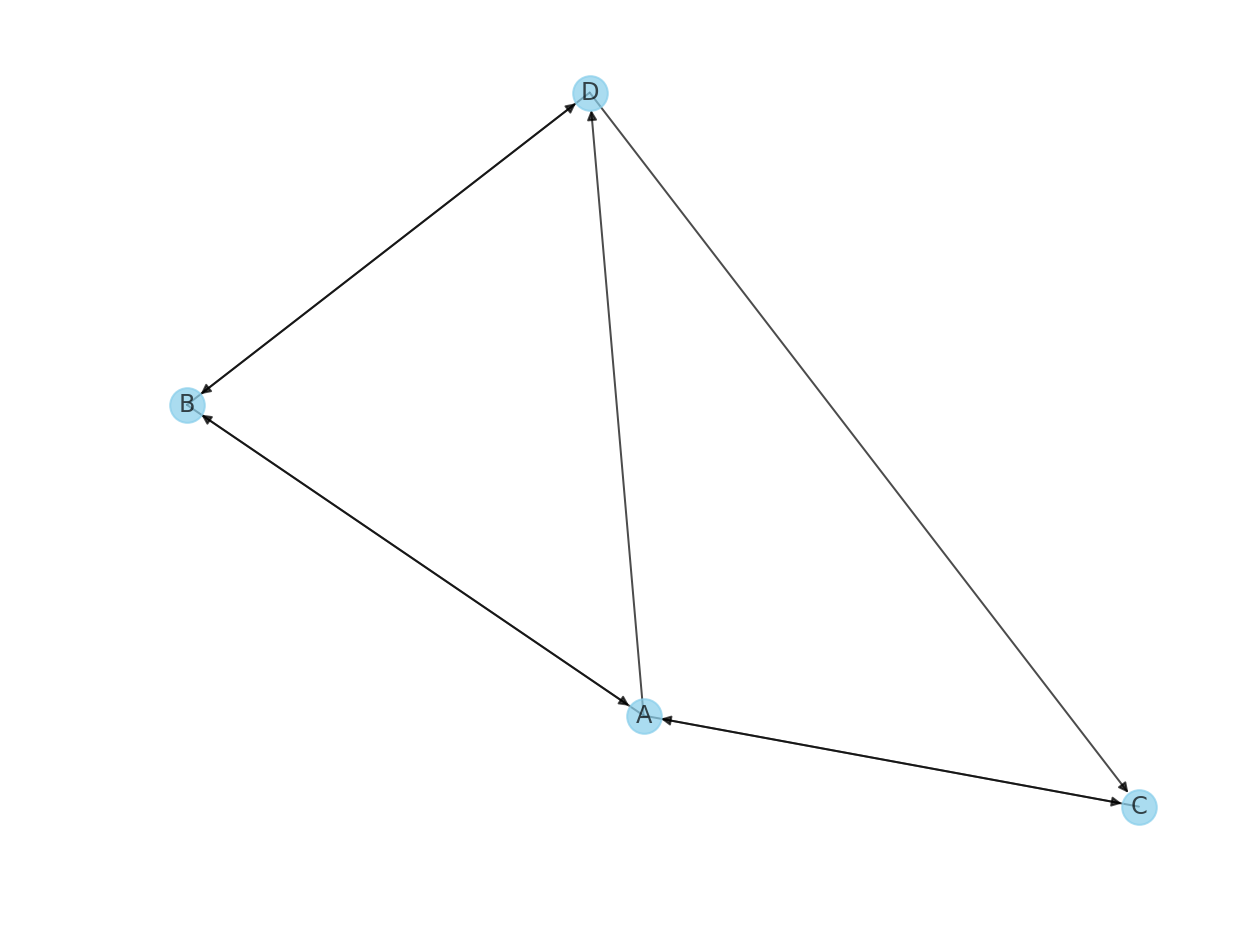

In [4]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# quick and dirty visualization of the graph we've defined above
nx.draw(graph, with_labels=True, node_color='skyblue', alpha=0.7)

Given this graph, we can build a transition matrix to depict what is the probability of landing on a given page after 1 step. If we look at an example below, the matrix has:

- $n$ rows and columns if there are $n$ pages
- Each element in the matrix, $m_{ij}$ takes on the value of $1 / k$ if page $i$ has $k$ edges and one of them is $j$. Otherwise $m_{ij}$ is 0.

In [5]:
trans_matrix = nx.to_numpy_array(graph)
trans_matrix /= trans_matrix.sum(axis=1, keepdims=True)
trans_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.5       , 0.        , 0.        , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ]])

Now suppose we start at any of the $n$ pages of the Web with equal probability. Then the initial vector $v_0$ will have $1/n$ for each page. If $M$ is the transition matrix of the Web, then after one step, the distribution
of us landing on each of the page can be computed by a matrix vector multiplication. $v_0 M$

In [6]:
n_nodes = trans_matrix.shape[0]
init_vector = np.repeat(1 / n_nodes, n_nodes)
init_vector @ trans_matrix

array([0.375     , 0.20833333, 0.20833333, 0.20833333])

As we can see after 1 step, the probability of landing on the first page, page $A$, is higher than the probability of landing on other pages. We can repeat this matrix vector multiplication for multiple times and our results will eventually converge. Giving us an estimated probability of landing on each page, which in term is PageRank's estimate of how important a given page is when compared to all the other page in the Web.

In [7]:
# we can tweak the number of iterations parameter
# and see that the resulting probability remains
# the same even if we increased the number to 50
n_iters = 30
result = init_vector
for _ in range(n_iters):
    result = result @ trans_matrix

result

array([0.33333333, 0.22222222, 0.22222222, 0.22222222])

This sort of convergence behavior is an example of the Markov Chain processes. It is known that the distribution of $v = Mv$ converges, provided two conditions are met:

- The graph is strongly connected; that is, it is possible to get from any
node to any other node.
- There are no dead ends: nodes that have no edges out.

If we stare at the formula $v = Mv$ long enough, we can observe that our final result vector $v$ is an eigenvector of the matrix $M$ (recall an eigenvector of a matrix $M$ is a vector $v$ that satisfies $v = \lambda Mv$ for some constant eigenvalue $\lambda$).

## Taxation

The vanilla PageRank that we've introduced above needs some tweaks to handle data that can appear in real world scenarios. The two problems that we need to avoid is what's called **spider traps** and **dead end**.

**spider trap** is a set of nodes with edges, but these edges all links within the page itself. This causes the PageRank calculation to place all the PageRank score within the spider traps.

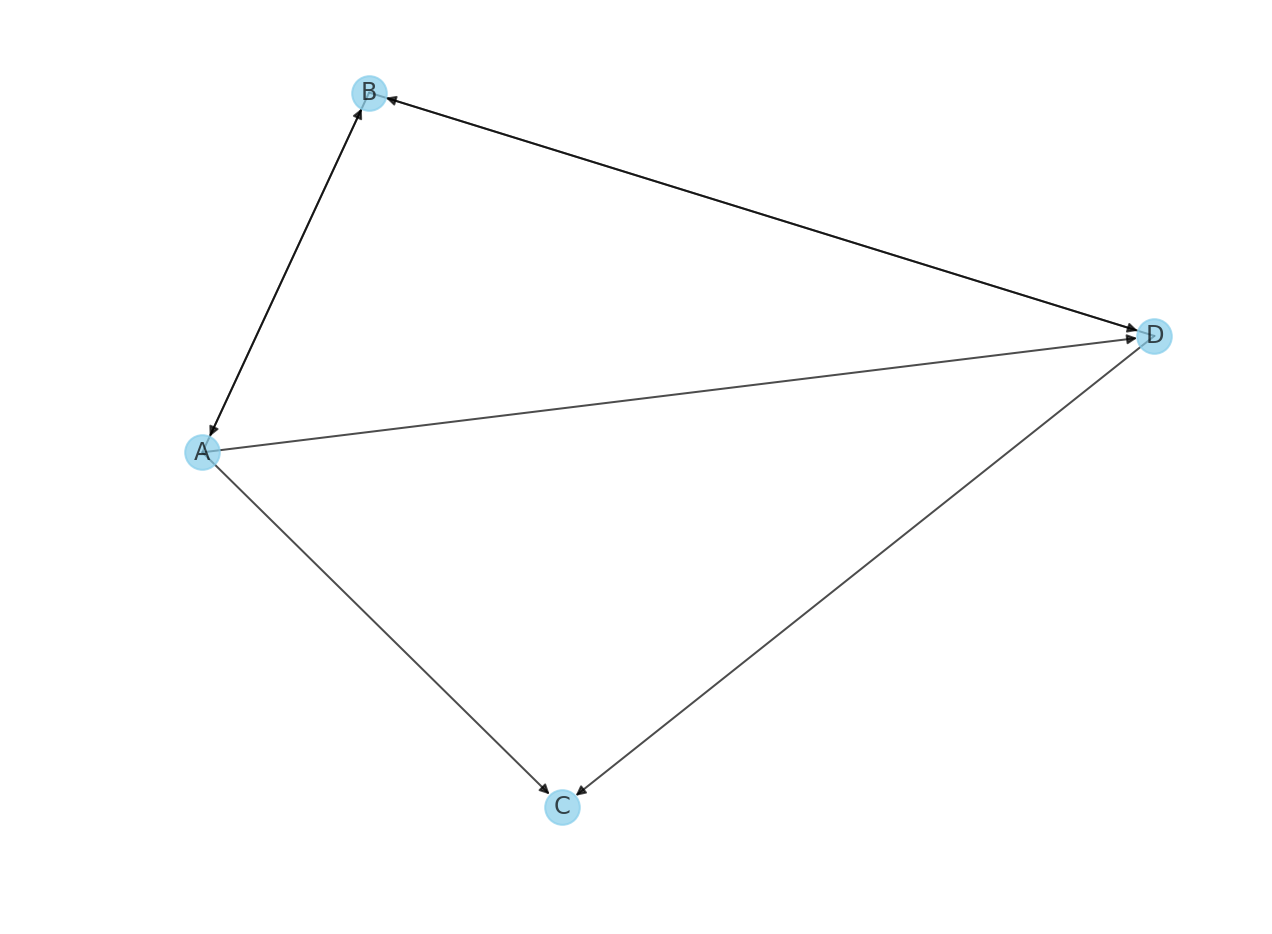

In [8]:
# we replaced C's out-link, ('C', 'A'),
# from the list of edges with a link within
# the page itself ('C', 'C'), note that
# we can also avoid this problem by note
# including self-loops in the edges
nodes = ['A', 'B', 'C', 'D']
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'D'),
    ('B', 'A'),
    ('B', 'D'),
    ('D', 'B'),
    ('D', 'C'),
    ('C', 'C')
]

graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)

# not showing the self-loop edge for node C
nx.draw(graph, with_labels=True, node_color='skyblue', alpha=0.7)

In [9]:
# notice in the transition probability matrix, the third row, node C
# contains 1 for a single entry
trans_matrix = nx.to_numpy_array(graph)
trans_matrix /= trans_matrix.sum(axis=1, keepdims=True)
trans_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ]])

In [10]:
n_iters = 40
result = init_vector
for _ in range(n_iters):
    result = result @ trans_matrix

result

array([6.04874159e-07, 8.81559995e-07, 9.99997632e-01, 8.81559995e-07])

As predicted, all the PageRank is at node $C$, since once we land there, there's no way for us to leave.

The other problem **dead end** describes pages that have no out-links, as a result pages that reaches these dead ends will not have any PageRank.

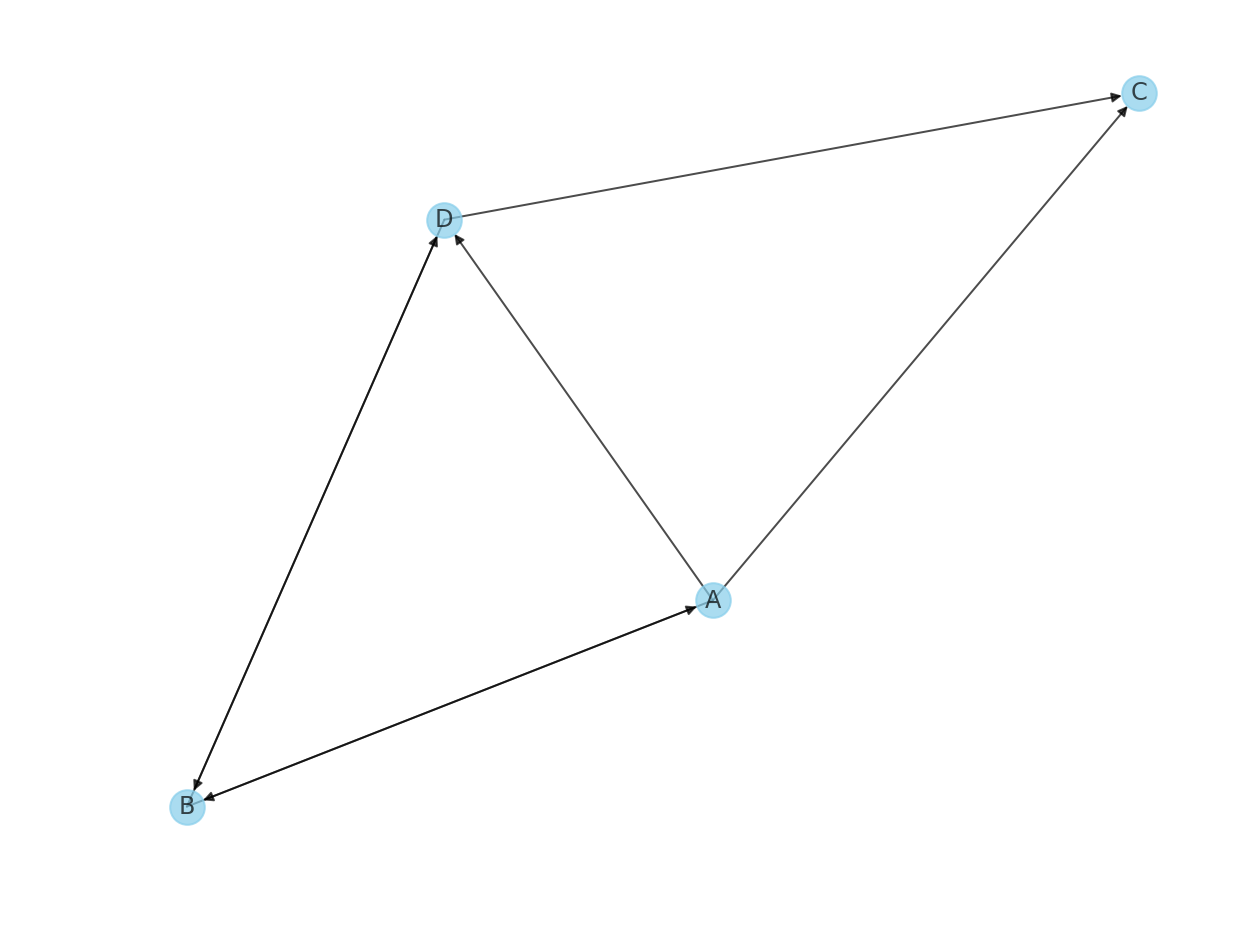

In [11]:
# we remove C's out-link, ('C', 'A'),
# from the list of edges
nodes = ['A', 'B', 'C', 'D']
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'D'),
    ('B', 'A'),
    ('B', 'D'),
    ('D', 'B'),
    ('D', 'C')
]

graph = nx.DiGraph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
nx.draw(graph, with_labels=True, node_color='skyblue', alpha=0.7)

In [12]:
# trick for numpy for dealing with zero division
# https://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero
trans_matrix = nx.to_numpy_array(graph)
summed = trans_matrix.sum(axis=1, keepdims=True)
trans_matrix = np.divide(trans_matrix, summed,
                         out=np.zeros_like(trans_matrix), where=summed!=0)

# notice in the transition probability matrix, the third row, node C
# consists of all 0
trans_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.5       , 0.        , 0.        , 0.5       ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.5       , 0.        ]])

In [13]:
n_iters = 40
result = init_vector
for _ in range(n_iters):
    result = result @ trans_matrix

result

array([6.04874159e-07, 8.81559995e-07, 8.81559995e-07, 8.81559995e-07])

As we see, the result tells us the probability of us being anywhere goes to 0, as the number of steps increase.

To avoid the two problems mentioned above, we will modify the calculation of PageRank. At each step, we will give it a small probability of "teleporting" to a random page, rather than following an out-link from their current page. The notation form for the description above would be:

\begin{align}
v^\prime = \beta M v + (1 - \beta) e / n
\end{align}

where:

- $\beta$ is a chosen constant, usually in the range of 0.8 to 0.9.
- $e$ is a vector of all 1s with the appropriate number of elements so that the matrix addition adds up.
- $n$ is the number of pages/nodes in the Web graph.
- The term, $\beta M v$ denotes that at this step, there is a probability $\beta$ that we will follow an out-link from their present page.
- Notice the term $(1 - \beta) e / n$ does not depend on $v$, thus if there are some dead ends in the graph, there will always be some fraction of opportunity to jump out of that rabbit hole.
- This idea of adding $\beta$ is referred to as taxation (`networkx` package calls this damping factor).

In [14]:
def build_trans_matrix(graph: nx.DiGraph, beta: float=0.9) -> np.ndarray:
    n_nodes = len(graph)
    trans_matrix = nx.to_numpy_array(graph)

    # assign uniform probability to dangling nodes (nodes without out links)
    const_vector = np.repeat(1.0 / n_nodes, n_nodes)
    row_sum = trans_matrix.sum(axis=1)
    dangling_nodes = np.where(row_sum == 0)[0]
    if len(dangling_nodes):
        for node in dangling_nodes:
            trans_matrix[node] = const_vector
            row_sum[node] = 1

    trans_matrix /= row_sum.reshape(-1, 1)
    return beta * trans_matrix + (1 - beta) * const_vector


trans_matrix = build_trans_matrix(graph)
trans_matrix

array([[0.025, 0.325, 0.325, 0.325],
       [0.475, 0.025, 0.025, 0.475],
       [0.25 , 0.25 , 0.25 , 0.25 ],
       [0.025, 0.475, 0.475, 0.025]])

In [15]:
n_iters = 20
result = init_vector
for _ in range(n_iters):
    result = result @ trans_matrix

result

array([0.20408163, 0.26530612, 0.26530612, 0.26530612])

The result looks much more reasonable after introducing the taxation. We can also compare the it with the `pagerank` function from `networkx`.

In [16]:
pagerank_score = nx.pagerank(graph, alpha=0.9)
pagerank_score

{'A': 0.204081934263649,
 'B': 0.265306021912117,
 'C': 0.265306021912117,
 'D': 0.265306021912117}

Having seen how to calculate the PageRank vector, we should examine how this information is being used. Of course each search engine has its own secret formula that decides the ordering of pages in response to users search query. But we can guess that first, in order to be considered for the ranking at all, a page has to have at least one of the search terms in the query. Then amongst the qualified pages, a score is computed for each, and an important component of this score is the PageRank of the page (we can think of component as a feature to a machine learning ranker). Other components might include the presence or absence of search terms in prominent places, such as headers or the links to
the page itself.

# Reference

- [Networkx Documentation: PageRank](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html)
- [Online Book: Mining Massive Dataset - Chapter 5 Link Analysis](http://infolab.stanford.edu/~ullman/mmds/book.pdf)